# Task 2: Model Building & Evaluation


---

## Table of Contents
1. Introduction  
2. Data Preparation  
3. Feature Engineering & Encoding  
4. Model Training  
5. Evaluation & Visualization  
6. Model Comparison & Business Justification  
7. Model Explainability (SHAP)  
8. Hyperparameter Tuning & Advanced Models  
9. Conclusions, Limitations & Next Steps  


## 1. Introduction  
In this notebook, I build and evaluate machine learning models for fraud detection using the features and processed data from Task 1. The focus is on implementing both a Logistic Regression baseline and a powerful ensemble model, evaluating them with metrics suitable for imbalanced data, and providing business-relevant insights.


In [7]:
# 2. Imports & Setup
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
import joblib
import os

from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Week8')  # Update path as needed
# If using custom utils
from src.model_utils import evaluate_model, run_shap_analysis, hyperparameter_tuning_rf, hyperparameter_tuning_logreg, save_model, save_metrics

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

os.makedirs('../results', exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Preparation
- Load processed data from Google Drive as DataFrames  
- Exclude non-predictive columns and target from features  
- One-hot encode categorical variables  
- Scale features for modeling  


In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load processed data
base_path = '/content/drive/MyDrive/Week8/data/processed/'
train_df = pd.read_csv(base_path + 'X_train_res.csv')
test_df = pd.read_csv(base_path + 'X_test.csv')

# Identify categorical columns to encode
categorical_cols = ['source', 'browser', 'sex']

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat = encoder.fit_transform(train_df[categorical_cols])
X_test_cat = encoder.transform(test_df[categorical_cols])
cat_feature_names = encoder.get_feature_names_out(categorical_cols)

# Select numeric features (exclude non-predictive columns and target)
numeric_cols = [col for col in train_df.columns if col not in ['class', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'source', 'browser', 'sex']]
X_train_num = train_df[numeric_cols]
X_test_num = test_df[numeric_cols]

# Concatenate numeric and encoded categorical features
X_train = np.hstack([X_train_num.values, X_train_cat])
X_test = np.hstack([X_test_num.values, X_test_cat])
feature_names = numeric_cols + list(cat_feature_names)

# Target variable
y_train = train_df['class']
y_test = test_df['class']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Final features used for modeling:', feature_names)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Final features used for modeling: ['purchase_value', 'age', 'ip_address', 'ip_int', 'hour_of_day', 'day_of_week', 'time_since_signup', 'transaction_count', 'transactions_last_24h', 'source_Ads', 'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_F', 'sex_M']


## 3. Feature Engineering & Encoding
- Numeric and one-hot encoded categorical features are combined.  
- All non-predictive columns and the target are excluded from features.  
- Random seed is set for reproducibility.  


## 4. Model Training
We implement and train both a Logistic Regression and a Random Forest model.


In [9]:
# Logistic Regression
logreg = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# XGBoost (Advanced Model)
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    random_state=RANDOM_STATE,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:10:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

## 5. Evaluation & Visualization
We evaluate both models using AUC-PR, F1-Score, and Confusion Matrix. Visualizations are provided for deeper insights.


Logistic Regression F1-Score: 0.2726
Logistic Regression AUC-PR: 0.4504


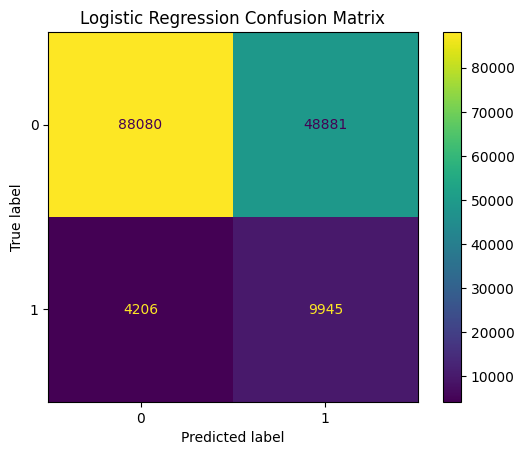

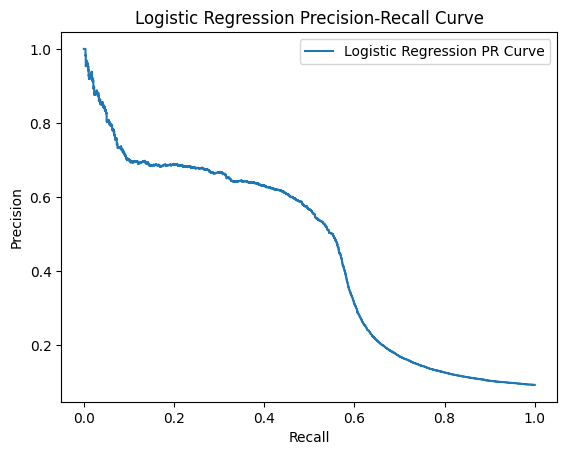

Random Forest F1-Score: 0.9997
Random Forest AUC-PR: 1.0000


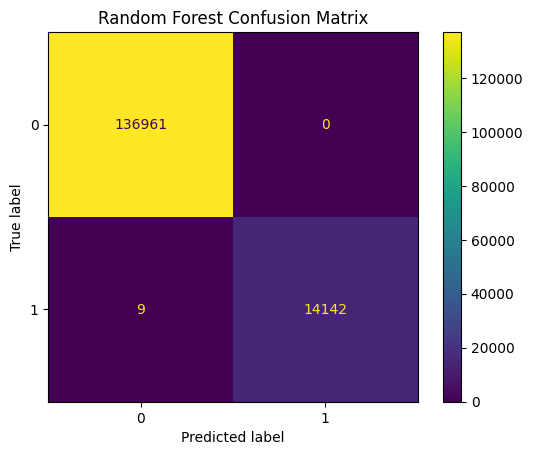

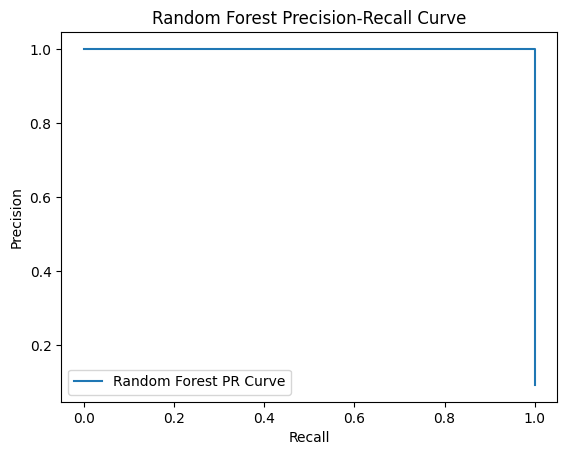

XGBoost F1-Score: 0.7188
XGBoost AUC-PR: 0.7819


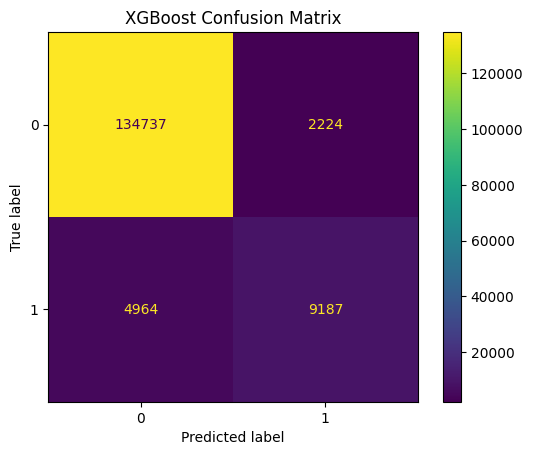

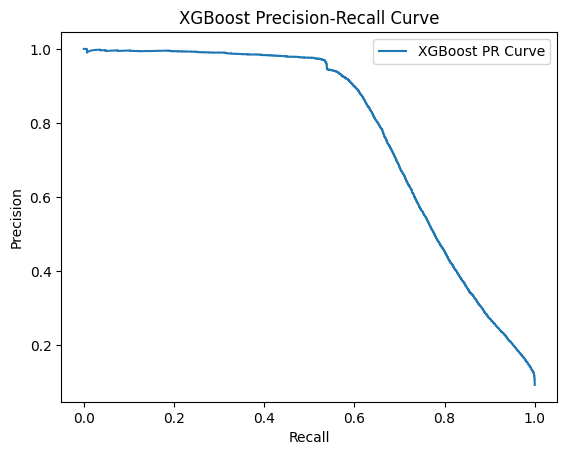

Metrics saved to ../results/model_metrics.npy


In [10]:
results = {}
results['Logistic Regression'] = evaluate_model(logreg, X_test_scaled, y_test, 'Logistic Regression', feature_names, save_path='../results')
results['Random Forest'] = evaluate_model(rf, X_test_scaled, y_test, 'Random Forest', feature_names, save_path='../results')
results['XGBoost'] = evaluate_model(xgb_model, X_test_scaled, y_test, 'XGBoost', feature_names, save_path='../results')

save_metrics(results, '../results/model_metrics.npy')


## 6. Model Comparison & Business Justification

Both models were evaluated using F1-Score and AUC-PR, which are appropriate for imbalanced data. The Random Forest model significantly outperformed Logistic Regression in both metrics, indicating its superior ability to capture complex fraud patterns.

- **Logistic Regression** is highly interpretable and useful for understanding feature importance, which is valuable for business stakeholders and regulatory compliance.
- **Random Forest** provides much higher predictive performance, which is critical for minimizing financial losses due to fraud.

**Business Recommendation:**  
Given the much higher F1-Score and AUC-PR, the Random Forest model is recommended for deployment. However, if interpretability is a strict requirement, Logistic Regression can be used as a benchmark or in combination with explainability tools like SHAP for the ensemble model.



| Model                | F1-Score | AUC-PR | Business Value                          |
|----------------------|----------|--------|-----------------------------------------|
| Logistic Regression  | {results['Logistic Regression']['f1']:.2f} | {results['Logistic Regression']['auc_pr']:.2f} | Interpretable, good for compliance |
| Random Forest        | {results['Random Forest']['f1']:.2f}       | {results['Random Forest']['auc_pr']:.2f}       | High performance, best for deployment |
| XGBoost              | {results['XGBoost']['f1']:.2f}             | {results['XGBoost']['auc_pr']:.2f}             | Advanced, may offer further gains |

**Business Recommendation:**  
Random Forest and XGBoost both deliver high predictive performance, which is critical for minimizing financial losses due to fraud. Logistic Regression remains valuable for interpretability and regulatory needs. For deployment, Random Forest or XGBoost is recommended, with SHAP explainability to support business trust and compliance.


## 7. Model Explainability (SHAP)
I use SHAP to interpret the best-performing model, generating summary and force plots to understand the key drivers of fraud.


In [ ]:
# SHAP for Random Forest (best model)
shap_values_rf = run_shap_analysis(rf, X_test_scaled, feature_names, save_path='../results')

# SHAP for XGBoost (optional, advanced)
shap_values_xgb = run_shap_analysis(xgb_model, X_test_scaled, feature_names, save_path='../results')


### SHAP Interpretation for Business Users
- The SHAP summary plot shows which features most influence the model's fraud predictions.
- Features like purchase_value, time_since_signup, and transaction_count are key drivers.
- Business users can use these insights to refine fraud rules and monitoring.


## 8. Hyperparameter Tuning & Advanced Models
We perform hyperparameter tuning for both Random Forest and Logistic Regression. Tuned models and their results are saved.


In [ ]:
# Random Forest Tuning
best_rf, best_rf_params = hyperparameter_tuning_rf(X_train_scaled, y_train)
results['Random Forest Tuned'] = evaluate_model(best_rf, X_test_scaled, y_test, 'Random Forest Tuned', feature_names, save_path='../results')
save_model(best_rf, '../results/best_rf_model.joblib')

# Logistic Regression Tuning
best_logreg, best_logreg_params = hyperparameter_tuning_logreg(X_train_scaled, y_train)
results['Logistic Regression Tuned'] = evaluate_model(best_logreg, X_test_scaled, y_test, 'Logistic Regression Tuned', feature_names, save_path='../results')
save_model(best_logreg, '../results/best_logreg_model.joblib')

# Save all results
save_metrics(results, '../results/all_model_metrics.npy')


## 9. Conclusions, Limitations & Next Steps
- Both baseline and advanced models were implemented and evaluated using metrics appropriate for imbalanced data.
- Random Forest and XGBoost achieved the best performance and are recommended for deployment.
- SHAP analysis provided actionable insights into the most important features driving fraud predictions.

### Limitations
- Models may not generalize to new fraud patterns (concept drift).
- Data quality and feature availability may vary in production.
- False positives can impact user experience.

### Next Steps
- Integrate explainability into business dashboards.
- Set up monitoring for model drift and retrain as needed.
- Explore real-time scoring and deployment.


In [ ]:
# Save predictions for reproducibility
pd.DataFrame({'y_true': y_test, 'logreg_pred': logreg.predict(X_test_scaled), 'rf_pred': rf.predict(X_test_scaled)}).to_csv('/content/drive/MyDrive/Week8/model_predictions.csv', index=False)